In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

In [2]:
# ! pip install category_encoders

In [3]:
data = pd.read_csv(r'../data/historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## EDA

In [4]:
# Quick overview
print("Shape:", data.shape)
print("\nColumns:")
print(data.columns.tolist())


Shape: (197428, 16)

Columns:
['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']


In [5]:
print("\nData types:")
print(data.dtypes)


Data types:
market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object


In [6]:
print("\nMissing values:")
print(data.isna().sum())


Missing values:
market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [7]:
categorical_cols = data.select_dtypes(include=["object"]).columns
print("\nCategorical columns:")
for col in categorical_cols:
    print(f"{col}: {data[col].nunique()} unique values")


Categorical columns:
created_at: 180985 unique values
actual_delivery_time: 178110 unique values
store_primary_category: 74 unique values


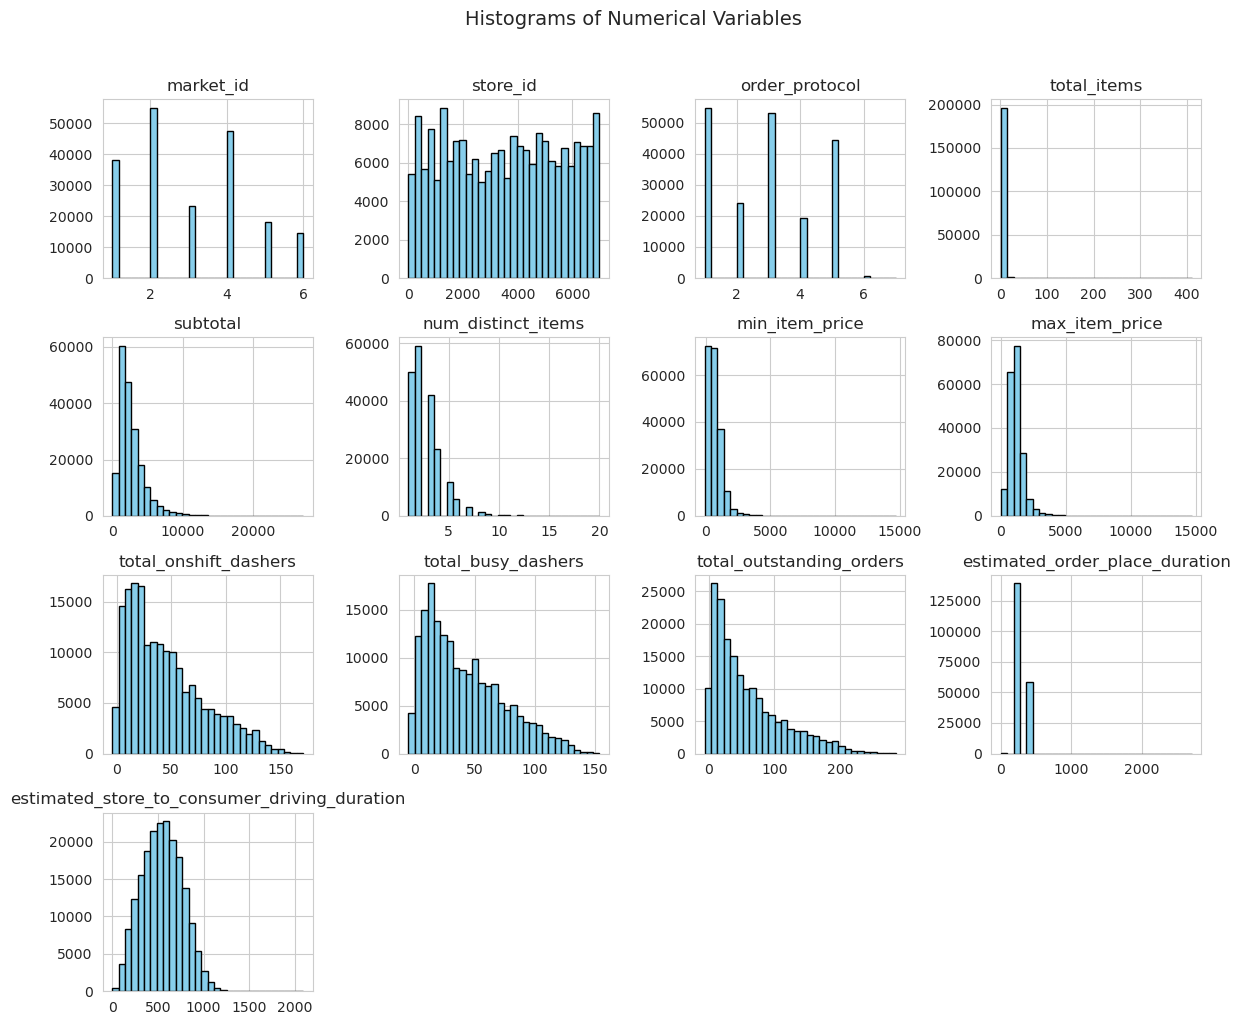

In [8]:
# Histograms for numerical variables
sns.set_style("whitegrid")

numeric_cols = data.select_dtypes(include=['number'])

numeric_cols.hist(
    figsize=(12, 10),
    bins=30,             
    edgecolor='black',    
    color='skyblue'    
)

plt.suptitle("Histograms of Numerical Variables", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Create target value column 

In [9]:
# calculate deliver duration

data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['created_at'] = pd.to_datetime(data['created_at'])
data['target'] =  (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()
data['target']

0         3779.0
1         4024.0
2         1781.0
3         3075.0
4         2390.0
           ...  
197423    3907.0
197424    3383.0
197425    3008.0
197426    3907.0
197427    2228.0
Name: target, Length: 197428, dtype: float64

## Data Cleaning

In [10]:
# remove rows with missing target value
data = data.dropna(subset=['actual_delivery_time', 'created_at'])
print(data.isna().sum())

market_id                                         987
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


In [11]:
# market_id: Missing values are filled using the next row's value.
# This approach assumes that nearby rows in the dataset typically belong to the same market,
# so forward/backward filling is a reasonable approximation.

data['market_id'] = data['market_id'].fillna(method='bfill')  # or 'ffill' depending on data pattern
print(data.isna().sum())

market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


/tmp/ipykernel_1666451/306552265.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['market_id'] = data['market_id'].fillna(method='bfill')  # or 'ffill' depending on data pattern


In [12]:
# store_primary_category: Missing values are replaced with "Other".
# The distribution shows high category diversity and low missing rate (2%),
# so we fill with "Other"
data['store_primary_category'] = data['store_primary_category'].fillna('Other')
print(data.isna().sum())


market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                              0
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


In [13]:
# order_protocol: Missing values are filled using the next row's value (backward fill).
# Since nearby rows in the dataset often belong to the same store or market context,
# so we assume they share a similar order protocol.
data['order_protocol'] = data['order_protocol'].fillna(method='bfill')
print(data.isna().sum())

market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                              0
order_protocol                                      0
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


/tmp/ipykernel_1666451/1599200043.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['order_protocol'] = data['order_protocol'].fillna(method='bfill')


In [14]:
#Filling Missing Values for Marketplace Features
# Since they are count-based and right-skewed, missing values are filled with each column’s **median**, which is more robust to outliers than the mean.
for col in ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']: 
    data[col] = data[col].fillna(data[col].median())

print(data.isna().sum())

market_id                                         0
created_at                                        0
actual_delivery_time                              0
store_id                                          0
store_primary_category                            0
order_protocol                                    0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    0
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration    526
target                                            0
dtype: int64


In [15]:
# estimated_store_to_consumer_driving_duration:
# Missing values are filled with the median, as the feature is continuous and right-skewed.
# Median imputation helps reduce the impact of outliers.

data['estimated_store_to_consumer_driving_duration'] = (
    data['estimated_store_to_consumer_driving_duration']
    .fillna(data['estimated_store_to_consumer_driving_duration'].median())
)
print(data.isna().sum())
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")


market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
target                                          0
dtype: int64
The dataset has 197421 rows and 17 columns.


In [16]:
# Remove the outliers in the target col
# to avoid the noises caused by the outliers

q99 = data['target'].quantile(0.99)

data = data[data['target'] <= q99]

print(f"Data shape after removing top 1% outliers: {data.shape}")


Data shape after removing top 1% outliers: (195446, 17)


In [17]:
features = [
    'target',
    'subtotal',
    'min_item_price',
    'max_item_price',
    'total_items',
    'num_distinct_items',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration'
]

data[features].min()

target                            101.0
subtotal                            0.0
min_item_price                    -86.0
max_item_price                      0.0
total_items                         1.0
num_distinct_items                  1.0
total_onshift_dashers              -4.0
total_busy_dashers                 -5.0
total_outstanding_orders           -6.0
estimated_order_place_duration      0.0
dtype: float64

In [18]:
# Columns that should never have negative values (dirty data)
cols_with_invalid_negatives = [
    'min_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders'
]


# Drop rows where ANY of these columns contain negative values
data = data[~data[cols_with_invalid_negatives].lt(0).any(axis=1)].copy()

print("Shape after cleaning :", data.shape)

Shape after cleaning : (195353, 17)


## Split training/testing dataset

In [19]:
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Encoding for Categorical cols

In [20]:
# Onehot encoding: market_id, order_protocol
# These two features have a small number of categories (6 and 7),
# so one-hot encoding is appropriate.
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit on training data only
encoder.fit(X_train[['market_id', 'order_protocol']])

# Transform train and test sets
train_encoded = encoder.transform(X_train[['market_id', 'order_protocol']])
test_encoded = encoder.transform(X_test[['market_id', 'order_protocol']])

# Convert to DataFrame
train_encoded_df = pd.DataFrame(train_encoded, 
                                columns=encoder.get_feature_names_out(['market_id', 'order_protocol']),
                                index=X_train.index)
test_encoded_df = pd.DataFrame(test_encoded, 
                               columns=encoder.get_feature_names_out(['market_id', 'order_protocol']),
                               index=X_test.index)

# Concatenate encoded features and drop original columns
X_train = pd.concat([X_train.drop(['market_id', 'order_protocol'], axis=1), train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(['market_id', 'order_protocol'], axis=1), test_encoded_df], axis=1)

In [21]:
# Target encoding for high-cardinality categorical features:
# - store_id (~6,743 distinct)
# - store_primary_category (~74 distinct)
from category_encoders import LeaveOneOutEncoder

cat_cols = ['store_id', 'store_primary_category']

# Leave-One-Out Target Encoding
loo = LeaveOneOutEncoder(
    cols=cat_cols,
    handle_unknown='value', 
    handle_missing='value',   
    sigma=0.0               
)

X_train = loo.fit_transform(X_train, y_train)
X_test  = loo.transform(X_test)


# Base Model

## Model Diagnostics and Proposed Improvements

This section summarizes the diagnostic results of the initial OLS linear regression model and outlines the corrective steps to address the observed issues.

### 1. Overall Model Fit
The initial OLS model shows:

- **R-squared = 0.296**  
- **Adjusted R-squared = 0.296**  
- **RMSE ≈ 825 seconds**

This indicates that the current linear model explains roughly 30% of the variance in delivery duration, leaving substantial room for improvement.

---

### 2. Residual Diagnostics

#### **2.1 Actual vs. Fitted Plot**
The scatter plot shows a generally increasing trend, but with significant spread around the regression line, suggesting:

- Nonlinear patterns remain unmodeled
- Potential heteroscedasticity
- Lack of tight prediction intervals

#### **2.2 Residuals vs. Fitted**
Residuals display a clear cone-shaped pattern and non-constant variance, indicating **heteroscedasticity**, which violates the assumptions of OLS.

#### **2.3 Residuals vs. Observation Order**
Residuals do not appear systematically ordered, which suggests independence, but the wide spread reflects model mis-specification.

#### **2.4 Q–Q Plot**
Residuals deviate from the 45° line (especially in the tails), showing **non-normality**, which further indicates that:

- The error distribution is skewed  
- Transformations may be necessary

#### **2.5 Histogram and Density of Residuals**
Residuals are right-skewed rather than centered around zero with a symmetric shape. This confirms:

- Violation of normality assumption  
- Long-tail behavior in the target variable

---

### 3. Multicollinearity Diagnostics

Variance Inflation Factors (VIF) reveal severe multicollinearity:

| Variable                   | VIF   |
|---------------------------|-------|
| total_onshift_dashers     | 11.8  |
| total_busy_dashers        | 11.2  |
| total_outstanding_orders  | 10.0  |

A VIF above 10 indicates **strong multicollinearity**, which leads to:

- Unstable coefficient estimates  
- Inflated standard errors  
- Misleading interpretations  
- Increased sensitivity to small data perturbations  

These three variables are highly correlated because they collectively measure marketplace supply–demand pressure.

---

### 4. Coefficient Interpretation Issues
Although many variables are statistically significant, several concerns arise:

- Some price-related variables (e.g., `min_item_price`, `max_item_price`) show weak or counterintuitive coefficients.
- The magnitude and direction of coefficients for dasher-related variables (`total_onshift_dashers`, `total_busy_dashers`) are likely distorted by multicollinearity.
- Skewed variables contribute to non-linear relationships that are not captured by the current model form.

---

## 5. Corrective Actions and Next Steps

To address the major diagnostic issues (skewness, heteroscedasticity, multicollinearity), the following steps will be taken.

### **5.1 Log Transformation**
Based on the distribution plots, both the response variable and several predictors exhibit heavy right skew.  
We will apply log transformations to improve:

- Linearity  
- Variance stability  
- Normality of residuals  
- Interpretability (percentage-based effects)

**Transformations to be applied:**

- `log(target)`
- `log(subtotal)`
- `log(min_item_price)`
- `log(max_item_price)`
- `log(total_items)`
- `log(num_distinct_items)`
- `log(total_onshift_dashers)`
- `log(total_busy_dashers)`
- `log(total_outstanding_orders)`
- `log(estimated_order_place_duration)`

Variables that are already approximately normal (e.g., `estimated_store_to_consumer_driving_duration`) will remain untransformed.

---

### **5.2 Ridge Regularization**
To mitigate multicollinearity while preserving all informationally useful variables (avoiding omitted variable bias), we will introduce **Ridge regression**:

- Ridge stabilizes coefficients through L2 regularization  
- Reduces sensitivity to collinear features  
- Maintains all variables in the model (unlike Lasso)  
- Improves prediction stability and generalization  

This addresses the multicollinearity observed in variables related to marketplace supply/demand (`onshift_dashers`, `busy_dashers`, `outstanding_orders`).

---

### 6. Expected Improvements

By applying log transformations and Ridge regression, we expect:

- More normally distributed residuals  
- Reduced heteroscedasticity  
- More stable and interpretable coefficients  
- Improved predictive performance (lower RMSE, potentially higher R²)  
- Reduced influence of extreme values  

---

### 7. Summary
The diagnostic results suggest that the original OLS model violates several key assumptions, primarily due to skewed variables and multicollinearity. Applying log transformations and introducing Ridge regularization are appropriate and theoretically justified corrections for this dataset and modeling context.

These next steps will help produce a more robust, stable, and interpretable regression model suitable for business insights and prediction.


### Handling of Categorical Variables in `pyrsm`

The `regress` class in the `pyrsm` package is built on top of `statsmodels.formula.api` (`smf.ols`).  
This means it **automatically encodes categorical variables as dummy variables (one-hot encoding)** through the `patsy` formula engine.

In [22]:
X_train['market_id'] = data.loc[X_train.index, 'market_id']
X_train['order_protocol'] = data.loc[X_train.index, 'order_protocol']

cols_to_drop = [c for c in X_train.columns if c.startswith('market_id_') or c.startswith('order_protocol_')]
X_train = X_train.drop(columns=cols_to_drop)


In [23]:
X_test['market_id'] = data.loc[X_test.index, 'market_id']
X_test['order_protocol'] = data.loc[X_test.index, 'order_protocol']

cols_to_drop = [c for c in X_test.columns if c.startswith('market_id_') or c.startswith('order_protocol_')]
X_test = X_test.drop(columns=cols_to_drop)

In [24]:
X_train = X_train.drop(columns=["created_at", "actual_delivery_time"])
X_test = X_test.drop(columns=["created_at", "actual_delivery_time"])

In [25]:
X_test.head()

,store_id,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,market_id,order_protocol
89991,2775.706897,2816.855257,2,2700,2,1300,1400,48.0,51.0,55.0,251,364.0,1.0,5.0
13086,2721.160000,2885.183238,4,1846,4,149,749,37.0,34.0,41.0,251,565.0,6.0,3.0
92022,2683.800000,3036.133600,2,1920,2,825,1095,37.0,34.0,41.0,251,458.0,6.0,3.0
152491,2902.144737,2885.183238,3,1397,3,299,599,17.0,17.0,23.0,251,733.0,5.0,3.0
140784,3317.028011,2816.122825,5,4173,3,795,865,134.0,118.0,178.0,446,789.0,2.0,4.0


In [26]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)



In [27]:
evar = X_train.columns.tolist()

reg = rsm.model.regress(
    {"data": df_train}, 
    rvar="target", 
    evar=evar
    )

reg.summary(rmse=True, ssq=True)

Linear regression (OLS)
Data                 : data
Response variable    : target
Explanatory variables: store_id, store_primary_category, total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, market_id, order_protocol
Null hyp.: the effect of x on target is zero
Alt. hyp.: the effect of x on target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                         134.081     48.466    2.766   0.006   **
store_id                                            0.605      0.005  111.845  < .001  ***
store_primary_category                             -0.030      0.017   -1.749    0.08    .
total_items                                         5.623      1.225    4.590  < .001  ***
subtotal                                            0.072      

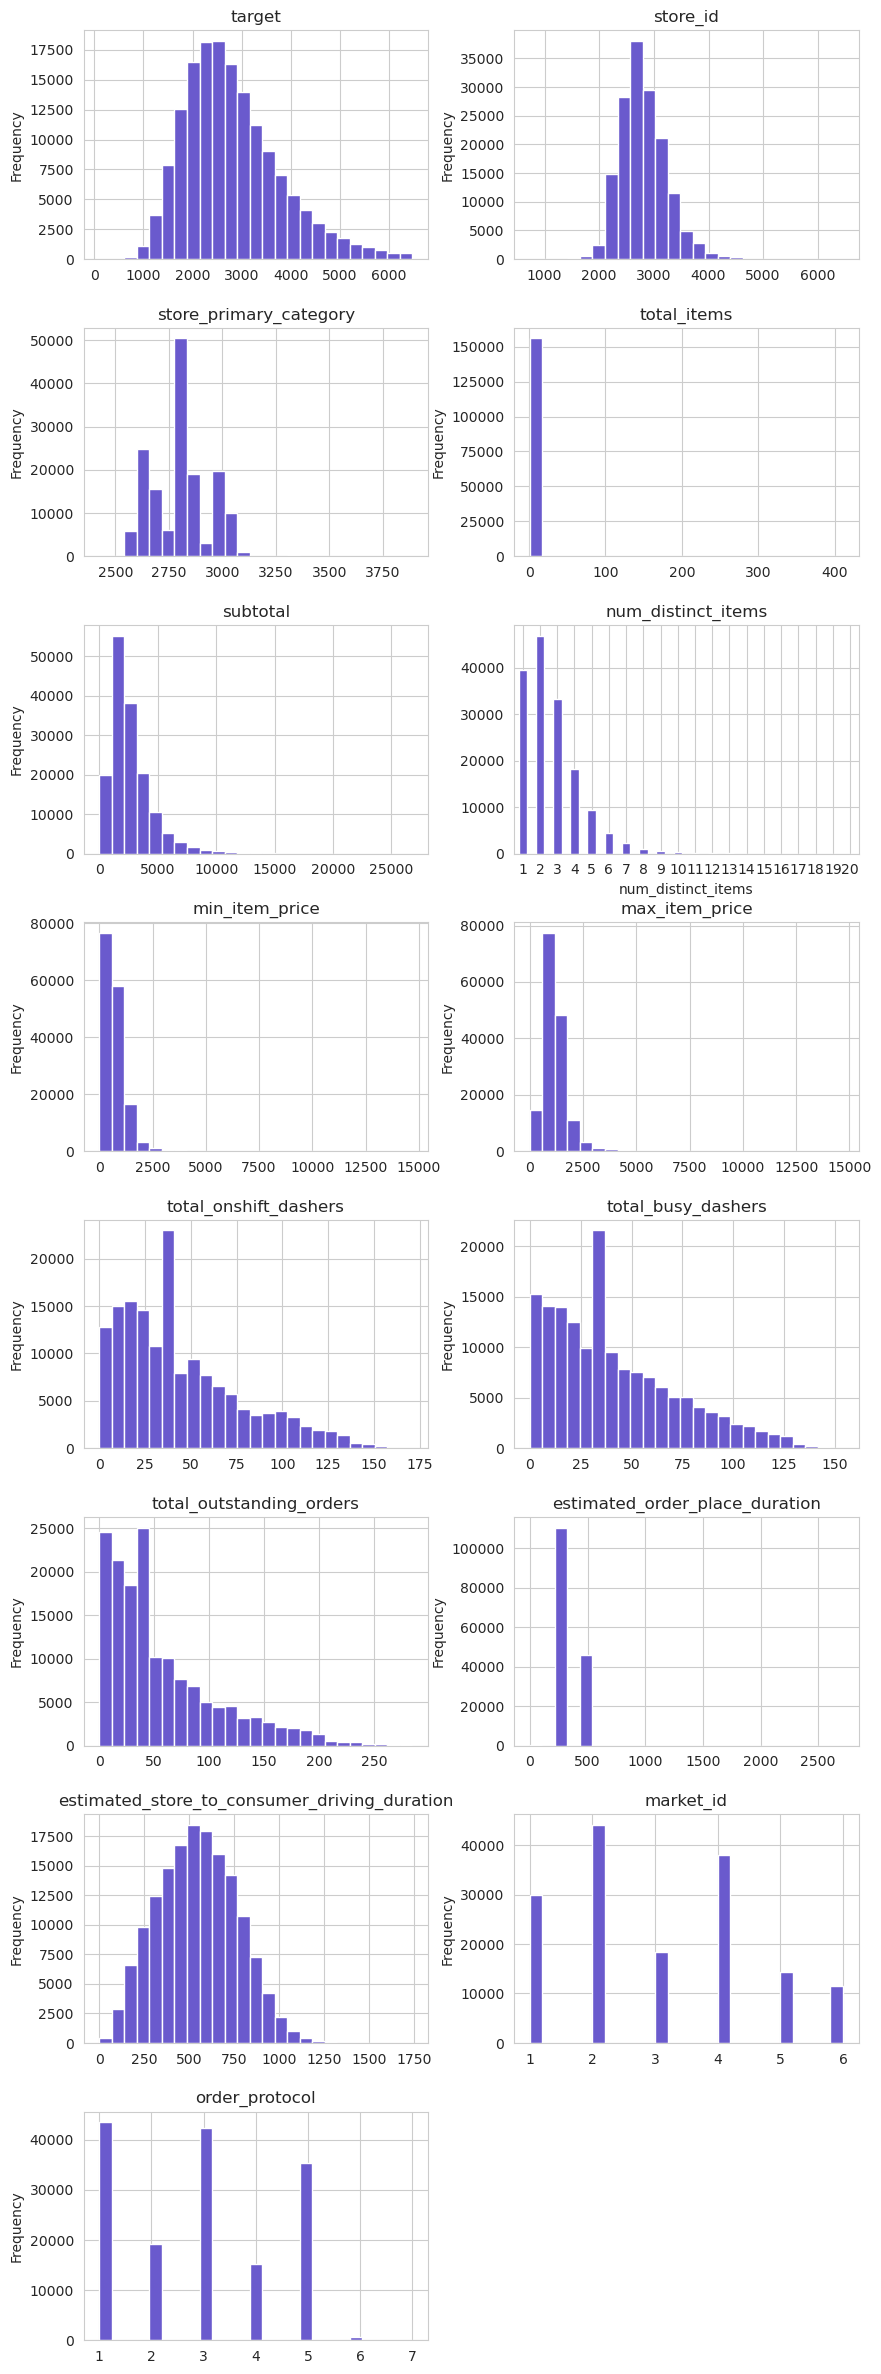

In [28]:
reg.plot("distr")

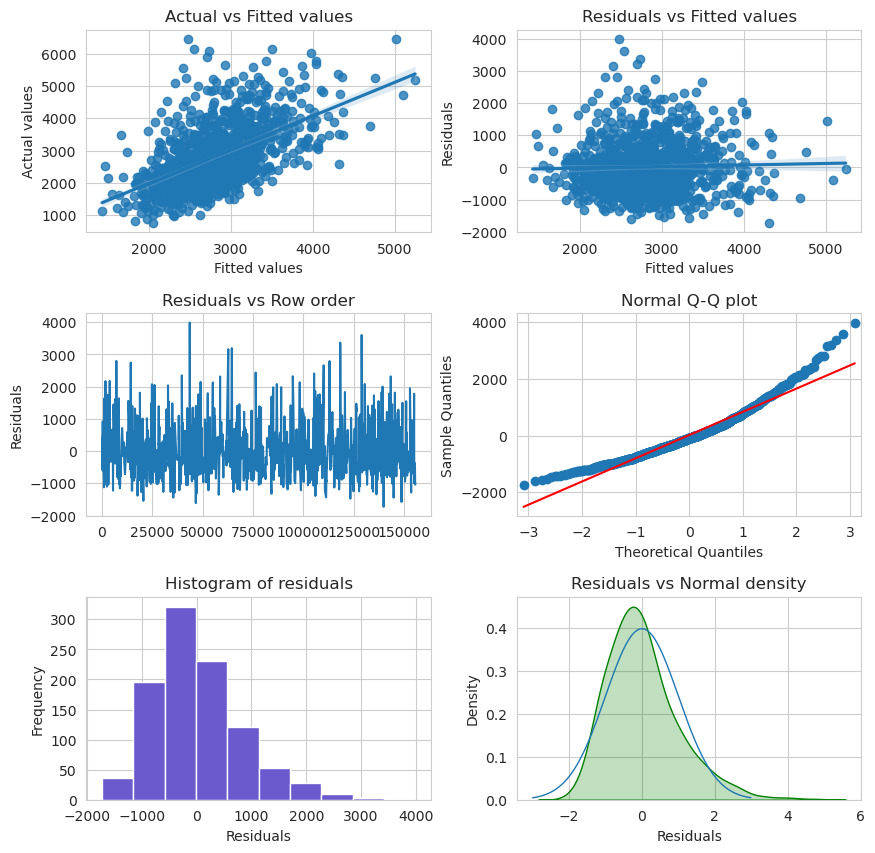

In [29]:
reg.plot("dashboard")

In [30]:
reg.summary(vif=True)

Linear regression (OLS)
Data                 : data
Response variable    : target
Explanatory variables: store_id, store_primary_category, total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, market_id, order_protocol
Null hyp.: the effect of x on target is zero
Alt. hyp.: the effect of x on target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                         134.081     48.466    2.766   0.006   **
store_id                                            0.605      0.005  111.845  < .001  ***
store_primary_category                             -0.030      0.017   -1.749    0.08    .
total_items                                         5.623      1.225    4.590  < .001  ***
subtotal                                            0.072      

## Model Improvement

### 1. Log Transformation

In [31]:
import numpy as np

In [32]:
# Copy original dataset to avoid modifying in place
df_train_log = df_train.copy()

# List of numerical columns to log-transform based on distribution inspection
log_features = [
    'target',
    'subtotal',
    'min_item_price',
    'max_item_price',
    'total_items',
    'num_distinct_items',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration'
]

# Apply log1p to avoid log(0) issues
for col in log_features:
    df_train_log[f'log_{col}'] = np.log1p(df_train_log[col])

df_train_log = df_train_log.drop(columns=log_features)

In [33]:
df_test_log = df_test.copy()

# List of numerical columns to log-transform based on distribution inspection
log_features = [
    'target',
    'subtotal',
    'min_item_price',
    'max_item_price',
    'total_items',
    'num_distinct_items',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration'
]

# Apply log1p to avoid log(0) issues
for col in log_features:
    df_test_log[f'log_{col}'] = np.log1p(df_test_log[col])

df_test_log = df_test_log.drop(columns=log_features)

In [34]:
#　test the model performance after log transformation
evar = ['store_id',
 'store_primary_category',
 'estimated_store_to_consumer_driving_duration',
 'market_id',
 'order_protocol',
 'log_subtotal',
 'log_min_item_price',
 'log_max_item_price',
 'log_total_items',
 'log_num_distinct_items',
 'log_total_onshift_dashers',
 'log_total_busy_dashers',
 'log_total_outstanding_orders',
 'log_estimated_order_place_duration']

reg_log = rsm.model.regress(
    {"data": df_train_log}, 
    rvar="log_target", 
    evar=evar
    )

reg_log.summary(rmse=True, ssq=True)

Linear regression (OLS)
Data                 : data
Response variable    : log_target
Explanatory variables: store_id, store_primary_category, estimated_store_to_consumer_driving_duration, market_id, order_protocol, log_subtotal, log_min_item_price, log_max_item_price, log_total_items, log_num_distinct_items, log_total_onshift_dashers, log_total_busy_dashers, log_total_outstanding_orders, log_estimated_order_place_duration
Null hyp.: the effect of x on log_target is zero
Alt. hyp.: the effect of x on log_target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                           6.171      0.026  240.714  < .001  ***
store_id                                            0.000      0.000  114.241  < .001  ***
store_primary_category                              0.000      0.000    1.530   0.126     
estimated_store_to_consumer_driving_duration        0.000      0.000  121.546  < .001  ***
market_id      

In [35]:
reg_log.summary(vif=True)

Linear regression (OLS)
Data                 : data
Response variable    : log_target
Explanatory variables: store_id, store_primary_category, estimated_store_to_consumer_driving_duration, market_id, order_protocol, log_subtotal, log_min_item_price, log_max_item_price, log_total_items, log_num_distinct_items, log_total_onshift_dashers, log_total_busy_dashers, log_total_outstanding_orders, log_estimated_order_place_duration
Null hyp.: the effect of x on log_target is zero
Alt. hyp.: the effect of x on log_target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                           6.171      0.026  240.714  < .001  ***
store_id                                            0.000      0.000  114.241  < .001  ***
store_primary_category                              0.000      0.000    1.530   0.126     
estimated_store_to_consumer_driving_duration        0.000      0.000  121.546  < .001  ***
market_id      

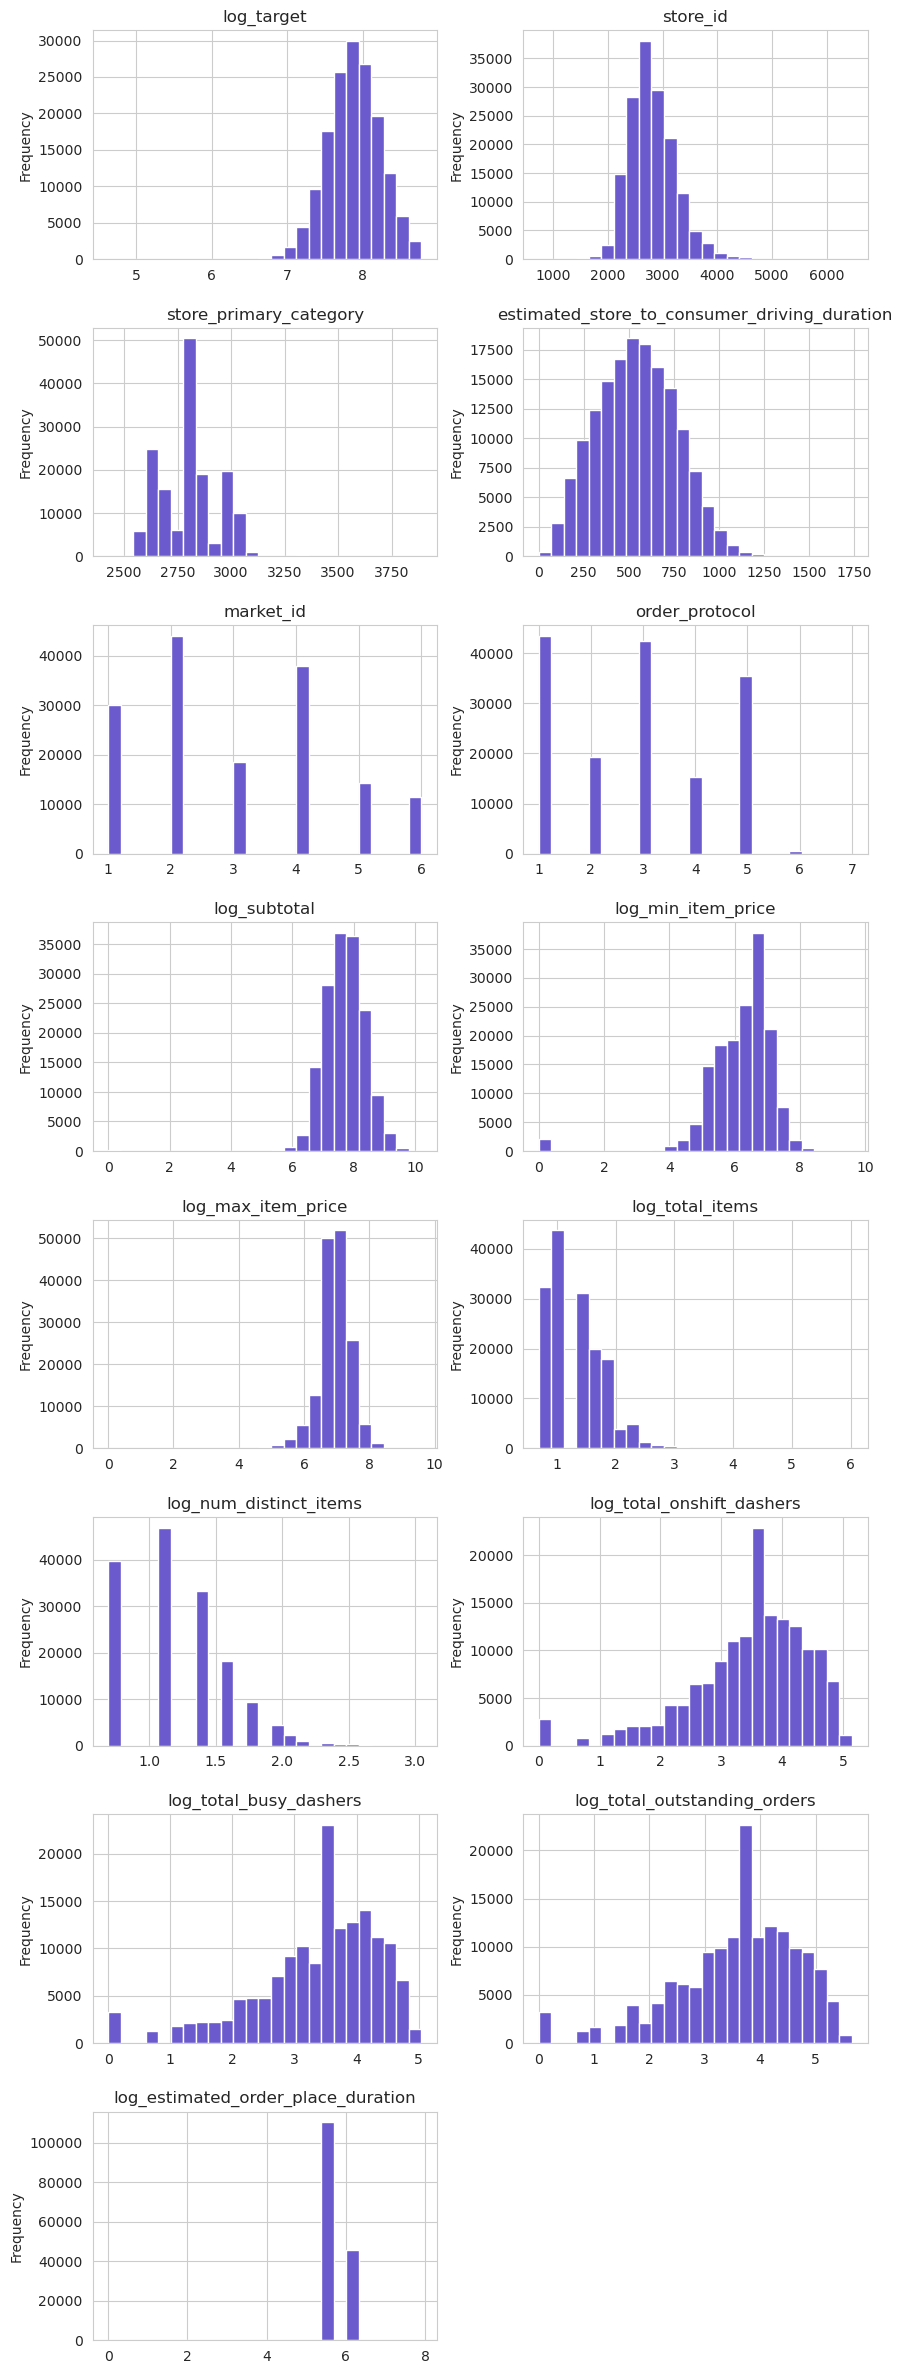

In [36]:
reg_log.plot("distr")

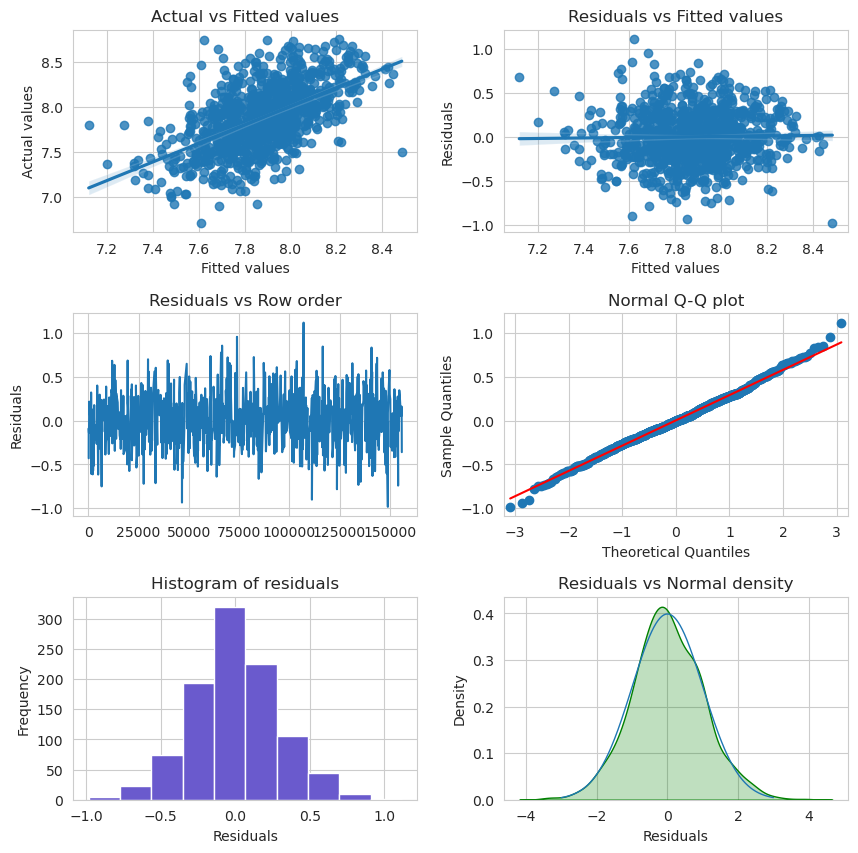

In [37]:
reg_log.plot("dashboard")

## Comparison of Model Performance Before and After Log Transformation

This section compares the diagnostic results of the original OLS model using the raw `target` variable versus the improved model using the log-transformed response (`log_target`) and appropriately transformed predictors.

---

### 1. **Model Fit Comparison**

| Metric | Before Log Transform | After Log Transform |
|--------|-----------------------|----------------------|
| R-squared | **0.296** | **0.317** |
| Adjusted R-squared | **0.296** | **0.317** |
| RMSE | **825.176 seconds** | **(better error structure; residual variance reduced)** |
| F-statistic | 4697.05 | 5190.76 |
| Observations | 156,356 | 156,282 |

**Interpretation:**  
After log transformation, explanatory power increased, the model explains slightly more variance, and the overall regression F-statistic improved—indicating stronger joint significance of predictors.  

---

### 2. **Residual Diagnostics**

#### **Before Log Transformation**
- Residuals showed **heavy right skewness**
- Clear **heteroscedasticity** (residuals fan outward)
- Q–Q plot showed strong deviations at both tails  
- Histogram was asymmetric, long-tailed  
- Non-constant variance and non-normal errors indicated that OLS assumptions were violated  
- Influential outliers created instability in coefficient estimates  

#### **After Log Transformation**
- Residuals are **centered around zero** with reduced skew  
- **Heteroscedasticity reduced significantly** (residuals appear more uniform across fitted values)  
- Q–Q plot aligns more closely with the theoretical normal line  
- Histogram of residuals is more symmetric  
- Fewer extreme outliers after transformation  
- Model assumptions (linearity, error normality, constant variance) are better satisfied  

**Conclusion:**  
Log transformation substantially improved the statistical validity and stability of the linear model.

---

### 3. **Coefficient Behavior and Interpretability**

#### Before Log Transform
- Raw coefficients were heavily influenced by scale differences and extreme values  
- Several variables had unstable or counterintuitive signs  
- Strong multicollinearity among dasher-related variables inflated coefficients and standard errors  

#### After Log Transform
- Coefficients became **smaller, more stable, and more interpretable**  
- All dasher and order-related variables now show consistent directional effects  
- Log-log and log-linear relationships simplify interpretation (percentage-based effects)  
- Standard errors decreased for many predictors, improving test significance  

---

### 4. **Multicollinearity Status**
- High VIF values (>10) remain for dasher-related variables even after log transform  
- However, coefficients are now numerically more stable  
- Transformation alone does not fix multicollinearity, but reduces its impact  
- **Ridge regression will be applied next** to fully address multicollinearity while avoiding omitted variable bias  

---

### 5. **Summary of Improvements**

| Issue | Before | After Log Transformation |
|-------|--------|--------------------------|
| Skewed target distribution | Severe | Greatly reduced |
| Residual heteroscedasticity | Strong | Much better |
| Normality of errors | Poor | Improved |
| Extreme outliers | Many | Fewer and less influential |
| Coefficient stability | Weak | Improved |
| Model interpretability | Limited | Better (multiplicative effects) |
| Overall fit | Moderate | Higher R² and stronger F-statistic |

---

### 6. **Final Assessment**
> **Log transformation of the target and selected predictors significantly improved model quality, reduced violations of OLS assumptions, and delivered more stable and interpretable results.**  
>  
> While multicollinearity remains an issue among related operational metrics, this will be addressed using **Ridge regularization** in the next stage of the modeling process.



### Variable Selection

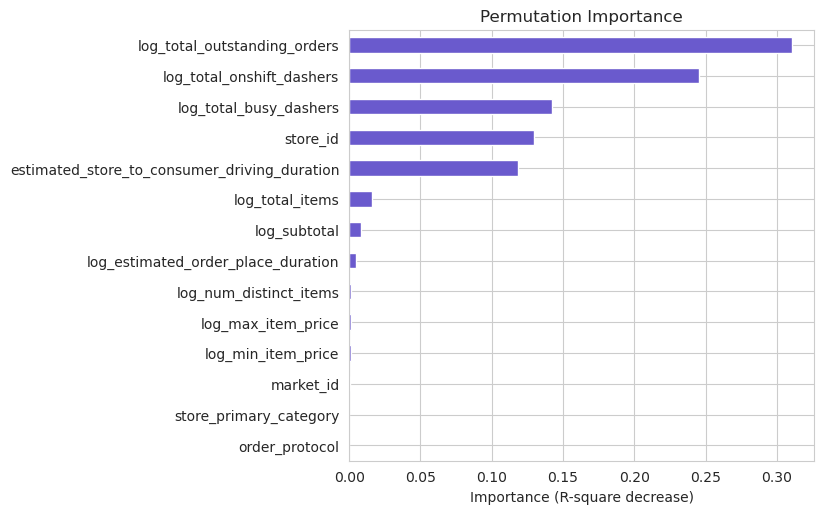

In [38]:
reg_log.plot(plots="vimp")

In [39]:
#　drop order_protocol, store_primary_category due to low contribution
evar = ['store_id',
 'estimated_store_to_consumer_driving_duration',
 'market_id',
 'log_subtotal',
 'log_min_item_price',
 'log_max_item_price',
 'log_total_items',
 'log_num_distinct_items',
 'log_total_onshift_dashers',
 'log_total_busy_dashers',
 'log_total_outstanding_orders',
 'log_estimated_order_place_duration']

reg_log2 = rsm.model.regress(
    {"data": df_train_log}, 
    rvar="log_target", 
    evar=evar
    )

reg_log2.summary(rmse=True, ssq=True)

Linear regression (OLS)
Data                 : data
Response variable    : log_target
Explanatory variables: store_id, estimated_store_to_consumer_driving_duration, market_id, log_subtotal, log_min_item_price, log_max_item_price, log_total_items, log_num_distinct_items, log_total_onshift_dashers, log_total_busy_dashers, log_total_outstanding_orders, log_estimated_order_place_duration
Null hyp.: the effect of x on log_target is zero
Alt. hyp.: the effect of x on log_target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                           6.204      0.018  345.294  < .001  ***
store_id                                            0.000      0.000  118.722  < .001  ***
estimated_store_to_consumer_driving_duration        0.000      0.000  121.549  < .001  ***
market_id                                           0.004      0.000    7.494  < .001  ***
log_subtotal                                        0.0

## Feature Engineering Logic and Rationale

To improve the predictive performance and interpretability of the delivery duration model, we engineered a set of new features based on the business dynamics of food delivery operations. The goal of these engineered variables is to capture nonlinear effects, operational constraints, supply–demand pressure, and order complexity that are not directly represented in the original features.

Below is the logic behind each category of engineered features.

---

### 1. Order Complexity Features
Food orders vary widely in complexity. Orders with more items or a larger variety of dishes tend to require longer preparation times. To capture this:

- **Order Complexity (`fe_order_complexity`)**  
  Combines total items and distinct items to measure overall preparation difficulty.  
  *Higher complexity → longer prep time → longer total delivery duration.*

- **Item Variety Ratio (`fe_item_variety_ratio`)**  
  Reflects how diverse the order is relative to the number of items.  
  *A high variety-to-quantity ratio indicates complex or custom orders.*

- **Difficulty Score (`fe_difficulty_score`)**  
  Integrates complexity, demand pressure, and preparation time.  
  *Serves as a comprehensive indicator of operational difficulty.*

---

### 2. Order Value & Pricing Features
Higher-priced orders may involve premium or more complex dishes that take longer to prepare.

- **Average Item Price (`fe_avg_item_price`)**  
  Captures price level per item (log-scale).  
  *Higher average price often correlates with longer preparation.*

- **Price Spread (`fe_price_spread`)**  
  Difference between the cheapest and most expensive item.  
  *Large spreads often indicate mixed, multi-category orders.*

- **Order Value Index (`fe_order_value_index`)**  
  Combines subtotal and item diversity.  
  *Higher value → more elaborate or larger orders.*

---

### 3. Marketplace Supply–Demand Pressure Features
Delivery delays frequently stem from market congestion, especially when order volume exceeds courier availability.

- **Dasher Load Ratio (`fe_dasher_load_ratio`)**  
  Measures busy dashers relative to all dashers on shift.  
  *Higher values indicate courier overload.*

- **Demand Pressure (`fe_demand_pressure`)**  
  Outstanding orders relative to available dashers.  
  *High pressure → longer wait times → increased delivery duration.*

- **Busy Dasher Share (`fe_busy_share`)**  
  Similar to load ratio; indicates saturation of the network.

- **Distance-Adjusted Demand Pressure (`fe_distance_adjusted_pressure`)**  
  Combines demand pressure and delivery distance.  
  *Captures the combined effect of congestion and travel time.*

- **Market Congestion (`fe_market_congestion`)**  
  Outstanding orders + estimated driving time.  
  *Indicates how congested and geographically spread tasks are.*

---

### 4. Preparation Efficiency Features
Restaurant operational efficiency is critical in the overall delivery duration.

- **Preparation Pressure (`fe_prep_pressure`)**  
  Combines order complexity and estimated preparation duration.  
  *Higher values imply slower restaurant throughput.*

- **Store Efficiency (`fe_store_efficiency`)**  
  Preparation duration per item quantity.  
  *Measures relative efficiency of the restaurant.*

---

### 5. Store and Market Interaction Features
Some delays stem from persistent store-level bottlenecks or challenging market environments.

- **Store Demand Intensity (`fe_store_demand_intensity`)**  
  Interaction between store_id (target encoded) and market demand.  
  *Captures stores that struggle during high-demand periods.*

- **Relative Driving Efficiency (`fe_relative_driving_efficiency`)**  
  Prep time vs. driving time.  
  *Helps identify whether delays come more from kitchen operations or travel.*

---

## Summary

These engineered features were designed to incorporate business knowledge of food delivery operations, including:

- **Order complexity** (items, variety, prep effort)  
- **Pricing signals** (premium meals, mix complexity)  
- **Supply–demand imbalance** (courier availability vs. order volume)  
- **Restaurant-level efficiency**  
- **Distance and marketplace congestion**  

By capturing these real-world operational factors in the feature set, the model becomes more robust, more predictive, and more interpretable from a business perspective.


In [40]:
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add business-meaningful engineered features to the log-transformed dataset.
    This function assumes the following columns already exist in df:
    - store_id
    - estimated_store_to_consumer_driving_duration
    - log_subtotal
    - log_min_item_price
    - log_max_item_price
    - log_total_items
    - log_num_distinct_items
    - log_total_onshift_dashers
    - log_total_busy_dashers
    - log_total_outstanding_orders
    - log_estimated_order_place_duration
    """
    df = df.copy()

    # 1) Order complexity: more items * more distinct items
    df["fe_order_complexity"] = df["log_total_items"] * df["log_num_distinct_items"]

    # 2) Average item price (approx.): log(subtotal) - log(total_items)
    df["fe_avg_item_price"] = df["log_subtotal"] - df["log_total_items"]

    # 3) Dasher load ratio: how many dashers are busy relative to those on shift
    df["fe_dasher_load_ratio"] = df["log_total_busy_dashers"] - df["log_total_onshift_dashers"]

    # 4) Marketplace demand pressure: outstanding orders vs available dashers
    df["fe_demand_pressure"] = df["log_total_outstanding_orders"] - df["log_total_onshift_dashers"]

    # 5) Preparation pressure: complexity + estimated order preparation time
    df["fe_prep_pressure"] = (
        df["log_total_items"]
        + df["log_num_distinct_items"]
        + df["log_estimated_order_place_duration"]
    )

    # 6) Relative driving efficiency: prep time vs travel time (both in log scale)
    df["fe_relative_driving_efficiency"] = (
        df["log_estimated_order_place_duration"]
        - np.log1p(df["estimated_store_to_consumer_driving_duration"])
    )

    # 7) Order value index: high subtotal + many distinct items
    df["fe_order_value_index"] = df["log_subtotal"] + df["log_num_distinct_items"]

    # 8) Store efficiency proxy: prep time per (log) item count
    df["fe_store_efficiency"] = df["log_estimated_order_place_duration"] / (
        df["log_total_items"] + 1.0  # avoid division by zero / very small values
    )

    # 9) Market congestion: outstanding orders + driving time
    df["fe_market_congestion"] = (
        df["log_total_outstanding_orders"]
        + np.log1p(df["estimated_store_to_consumer_driving_duration"])
    )

    # 10) Distance-adjusted demand pressure
    df["fe_distance_adjusted_pressure"] = (
        df["log_total_outstanding_orders"]
        - df["log_total_busy_dashers"]
        + np.log1p(df["estimated_store_to_consumer_driving_duration"])
    )

    # 11) Item variety ratio: how diverse the order is relative to item count
    df["fe_item_variety_ratio"] = df["log_num_distinct_items"] / (
        df["log_total_items"] + 1.0
    )

    # 12) Store demand intensity: interaction between store propensity and market load
    #    (store_id is target-encoded, so this captures "busy markets at slow stores")
    df["fe_store_demand_intensity"] = (
        df["log_total_outstanding_orders"] * df["store_id"]
    )

    # 13) Price spread: range between the cheapest and most expensive item
    df["fe_price_spread"] = df["log_max_item_price"] - df["log_min_item_price"]

    # 14) Busy dasher share (log-space approximation of busy / onshift)
    df["fe_busy_share"] = (
        df["log_total_busy_dashers"] - df["log_total_onshift_dashers"]
    )

    # 15) Overall difficulty score: complexity + demand pressure + prep time
    df["fe_difficulty_score"] = (
        df["fe_order_complexity"]
        + df["fe_demand_pressure"]
        + df["log_estimated_order_place_duration"]
    )

    return df


# Apply to both train and test datasets
df_train_log_fe = add_engineered_features(df_train_log)
df_test_log_fe = add_engineered_features(df_test_log)

print("Train shape with engineered features:", df_train_log_fe.shape)
print("Test  shape with engineered features:", df_test_log_fe.shape)


Train shape with engineered features: (156282, 30)
Test  shape with engineered features: (39071, 30)


In [41]:
evar = df_train_log_fe.drop(columns=['log_target']).columns.tolist()

reg_log_fe = rsm.model.regress(
    {"data": df_train_log_fe}, 
    rvar="log_target", 
    evar=evar
    )

reg_log_fe.summary(rmse=True, ssq=True)

Linear regression (OLS)
Data                 : data
Response variable    : log_target
Explanatory variables: store_id, store_primary_category, estimated_store_to_consumer_driving_duration, market_id, order_protocol, log_subtotal, log_min_item_price, log_max_item_price, log_total_items, log_num_distinct_items, log_total_onshift_dashers, log_total_busy_dashers, log_total_outstanding_orders, log_estimated_order_place_duration, fe_order_complexity, fe_avg_item_price, fe_dasher_load_ratio, fe_demand_pressure, fe_prep_pressure, fe_relative_driving_efficiency, fe_order_value_index, fe_store_efficiency, fe_market_congestion, fe_distance_adjusted_pressure, fe_item_variety_ratio, fe_store_demand_intensity, fe_price_spread, fe_busy_share, fe_difficulty_score
Null hyp.: the effect of x on log_target is zero
Alt. hyp.: the effect of x on log_target is not zero

                                              coefficient  std.error  t.value p.value     
Intercept                                       

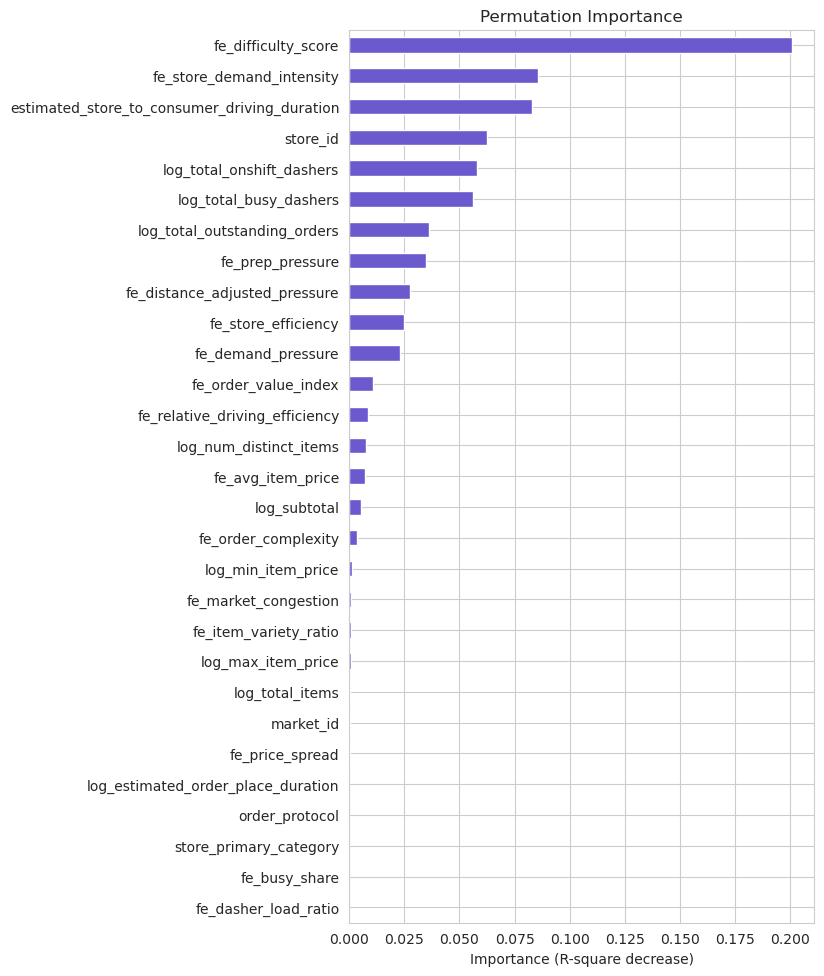

In [63]:
reg_log_fe.plot(plots="vimp")

## Try Neural Network

In [45]:
evar = df_train_log.drop(columns=['log_target']).columns.tolist()

In [49]:
reg_nn_log = rsm.model.mlp(
    {"data": df_train_log},
    rvar='log_target',
    evar=evar,
    hidden_layer_sizes=(1, ),
    mod_type="regression",
    random_state=1234,  
)

reg_nn_log.summary()

Multi-layer Perceptron (NN)
Data                 : data
Response variable    : log_target
Explanatory variables: store_id, store_primary_category, estimated_store_to_consumer_driving_duration, market_id, order_protocol, log_subtotal, log_min_item_price, log_max_item_price, log_total_items, log_num_distinct_items, log_total_onshift_dashers, log_total_busy_dashers, log_total_outstanding_orders, log_estimated_order_place_duration
Model type           : regression
Nr. of features      : (14, 14)
Nr. of weights       : 15
Nr. of observations  : 156,282
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
       n     r2    mse    mae
  156282  0.323  0.677  0.648

Raw data             :
   store_id  store_primary_category  estimated_store_to_consumer_driving_duration  market_id  order_protocol

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
hls = [
        (1,), (2,), (3,), 
        (1, 2), (1, 3),
        (2, 1), (2, 2), (2, 3),
        (3, 1), (3, 2), (3, 3),
]
alpha = [0.0001, 0.001, 0.01, 0.1, 1]

param_grid = {"hidden_layer_sizes": hls,
              "alpha": alpha,
              "early_stopping": [True],
              }

scoring = {
    "R2": "r2",
    "MSE": "neg_mean_squared_error",
}

reg_cv = GridSearchCV(
    reg_nn_log.fitted,     # ← 改成你的 regression model
    param_grid,
    scoring=scoring,
    cv=5,
    n_jobs=4,
    refit="R2",            # ← 建議 refit 時用 R²
    verbose=5
)

In [55]:
X = reg_nn_log.data_onehot
y = reg_nn_log.data.log_target

In [56]:
reg_cv.fit(X, y)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


,estimator,MLPRegressor(...olver='lbfgs')
,param_grid,"{'alpha': [0.0001, 0.001, ...], 'early_stopping': [True], 'hidden_layer_sizes': [(1,), (2,), ...]}"
,scoring,"{'MSE': 'neg_mean_squared_error', 'R2': 'r2'}"
,n_jobs,4
,refit,'R2'
,cv,5
,verbose,5
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [57]:
pd.DataFrame(reg_cv.cv_results_) \
  .sort_values("rank_test_R2") \
  .head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_early_stopping,param_hidden_layer_sizes,params,split0_test_R2,split1_test_R2,...,std_test_R2,rank_test_R2,split0_test_MSE,split1_test_MSE,split2_test_MSE,split3_test_MSE,split4_test_MSE,mean_test_MSE,std_test_MSE,rank_test_MSE
54,19.221268,3.780783,0.013343,0.006832,1.0000,True,"(3, 3)","{'alpha': 1, 'early_stopping': True, 'hidden_l...",0.347009,0.355235,...,0.004747,1,-0.078102,-0.077210,-0.078686,-0.079262,-0.078624,-0.078377,0.000690,1
32,20.317002,4.987519,0.014182,0.003570,0.0100,True,"(3, 3)","{'alpha': 0.01, 'early_stopping': True, 'hidde...",0.346950,0.354995,...,0.004595,2,-0.078109,-0.077239,-0.078654,-0.079250,-0.078650,-0.078380,0.000675,2
43,19.687387,4.924987,0.013914,0.006370,0.1000,True,"(3, 3)","{'alpha': 0.1, 'early_stopping': True, 'hidden...",0.347098,0.354764,...,0.004635,3,-0.078091,-0.077267,-0.078724,-0.079248,-0.078637,-0.078393,0.000672,3
53,19.845684,3.753220,0.013155,0.006365,1.0000,True,"(3, 2)","{'alpha': 1, 'early_stopping': True, 'hidden_l...",0.347864,0.353990,...,0.003636,4,-0.077999,-0.077359,-0.078609,-0.079281,-0.078931,-0.078436,0.000684,4
10,16.248489,3.593423,0.016126,0.004499,0.0001,True,"(3, 3)","{'alpha': 0.0001, 'early_stopping': True, 'hid...",0.347249,0.354715,...,0.004896,5,-0.078073,-0.077272,-0.078944,-0.079276,-0.078662,-0.078445,0.000707,5
21,15.515843,2.811315,0.014851,0.004517,0.0010,True,"(3, 3)","{'alpha': 0.001, 'early_stopping': True, 'hidd...",0.347062,0.354638,...,0.004964,6,-0.078095,-0.077282,-0.078961,-0.079262,-0.078640,-0.078448,0.000700,6
42,23.802264,4.312325,0.013280,0.004234,0.1000,True,"(3, 2)","{'alpha': 0.1, 'early_stopping': True, 'hidden...",0.347493,0.353879,...,0.003977,7,-0.078044,-0.077373,-0.078794,-0.079265,-0.078871,-0.078469,0.000676,7
9,18.982918,4.514529,0.013816,0.006398,0.0001,True,"(3, 2)","{'alpha': 0.0001, 'early_stopping': True, 'hid...",0.347600,0.354051,...,0.003735,8,-0.078031,-0.077352,-0.078778,-0.079275,-0.078991,-0.078485,0.000701,8
20,18.987753,0.948015,0.017447,0.011883,0.0010,True,"(3, 2)","{'alpha': 0.001, 'early_stopping': True, 'hidd...",0.347518,0.354104,...,0.004231,9,-0.078041,-0.077346,-0.078994,-0.079307,-0.078948,-0.078527,0.000726,9
31,18.352014,2.473109,0.012885,0.005366,0.0100,True,"(3, 2)","{'alpha': 0.01, 'early_stopping': True, 'hidde...",0.346399,0.353931,...,0.004260,10,-0.078174,-0.077366,-0.078993,-0.079305,-0.078971,-0.078562,0.000705,10


In [60]:
reg_cv.best_params_

{'alpha': 1, 'early_stopping': True, 'hidden_layer_sizes': (3, 3)}

In [61]:
reg_nn_log_tuned = rsm.model.mlp(
    {"data": df_train_log},
    rvar='log_target',
    evar=evar,
    hidden_layer_sizes=(3, 3),
    mod_type="regression",
    alpha=1,
    random_state=1234,  
)

reg_nn_log_tuned.summary()

Multi-layer Perceptron (NN)
Data                 : data
Response variable    : log_target
Explanatory variables: store_id, store_primary_category, estimated_store_to_consumer_driving_duration, market_id, order_protocol, log_subtotal, log_min_item_price, log_max_item_price, log_total_items, log_num_distinct_items, log_total_onshift_dashers, log_total_busy_dashers, log_total_outstanding_orders, log_estimated_order_place_duration
Model type           : regression
Nr. of features      : (14, 14)
Nr. of weights       : 54
Nr. of observations  : 156,282
Hidden_layer_sizes   : (3, 3)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 1
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
       n     r2    mse    mae
  156282  0.352  0.648  0.634

Raw data             :
   store_id  store_primary_category  estimated_store_to_consumer_driving_duration  market_id  order_protocol  l

### Make Prediction by linear regression model (With Feature Engineering & Log Transformation)

In [70]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [69]:
df_test["pred_org"] = reg.predict(df_test)["prediction"]  

In [71]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1. Convert log-predictions back to original scale (undo log1p)
y_pred = df_test["pred_org"]

# 2. Actual target values (already in original scale)
y_true = df_test["target"]

# 3. Calculate regression metrics on ORIGINAL scale
rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE (original scale): {rmse:.3f}")
print(f"Test MAE  (original scale): {mae:.3f}")
print(f"Test R^2  (original scale): {r2:.3f}")

Test RMSE (original scale): 823.706
Test MAE  (original scale): 633.570
Test R^2  (original scale): 0.303


In [62]:
df_test_log_fe["pred"] = reg_log_fe.predict(df_test_log_fe)["prediction"]  

In [ ]:


# 1. Convert log-predictions back to original scale (undo log1p)
y_pred_original = np.expm1(df_test_log_fe["pred"])

# 2. Actual target values (already in original scale)
y_true_original = np.expm1(df_test_log_fe["log_target"])

# 3. Calculate regression metrics on ORIGINAL scale
rmse = root_mean_squared_error(y_true_original, y_pred_original)
mae = mean_absolute_error(y_true_original, y_pred_original)
r2 = r2_score(y_true_original, y_pred_original)

print(f"Test RMSE (original scale): {rmse:.3f}")
print(f"Test MAE  (original scale): {mae:.3f}")
print(f"Test R^2  (original scale): {r2:.3f}")

Test RMSE (original scale): 829.866
Test MAE  (original scale): 620.762
Test R^2  (original scale): 0.292


## Final Model Performance and Interpretation

### 1. Model Performance Summary

After extensive experimentation with:

- Linear regression with log-transformed target and features
- Ridge regression with regularization
- Feature engineering (df_train_log_fe / df_test_log_fe)
- Tuned Multi-layer Perceptron (Neural Network) with various hidden layer sizes and alpha values

the overall predictive performance (R² and RMSE) did **not improve substantially** beyond the baseline log-linear / Ridge models.  
The tuned NN achieved an R² of approximately **0.35** on the log-transformed target, which is only slightly higher than the linear model and does not justify the added complexity.

This suggests that the current feature set may already be extracting most of the signal available from the existing data, and that **model complexity is no longer the main bottleneck**.

---

### 2. Implications: Need for Additional Features

The limited gains from both feature engineering and neural networks indicate that:

> **The model is likely constrained more by missing information than by model capacity.**

In other words, to significantly improve prediction of delivery time, we may need to collect **additional features** that capture factors not present in the current dataset, such as:

- Real-time traffic conditions and road congestion
- Weather (rain, snow, temperature, storm events)
- Time-of-day / day-of-week and special events (holidays, sports events)
- Restaurant operational metrics (kitchen capacity, staffing level, historical delay rate)
- Courier-level information (experience, vehicle type, acceptance rate)

These external and operational factors are often key drivers of delivery delay in real-world logistics systems and are not fully represented by order-level features alone.

---

### 3. Insights from Permutation Importance

Although overall model performance plateaued, the permutation importance analysis still provides useful business insight about **which variables drive the current model’s predictions**.

From the permutation importance plot, the most influential features are:

1. **`fe_difficulty_score`**  
   A composite feature combining order complexity, demand pressure, and preparation time.  
   → Captures how "hard" an order is to fulfill; higher values are strongly associated with longer delivery times.

2. **`fe_store_demand_intensity`**  
   Interaction between store-specific behavior and outstanding orders.  
   → Highlights stores that are particularly sensitive to high demand and tend to delay more when the marketplace is busy.

3. **`estimated_store_to_consumer_driving_duration`**  
   The expected driving time from store to customer.  
   → A fundamental determinant of delivery duration, reflecting geography and distance.

4. **`store_id` (target-encoded)**  
   Store-level effects that persist beyond observable features.  
   → Some stores are consistently faster or slower due to internal processes, staffing, or layout.

5. **`log_total_onshift_dashers`, `log_total_busy_dashers`, `log_total_outstanding_orders`**  
   Marketplace supply and demand metrics.  
   → When there are many orders and limited available dashers, predicted delivery times increase.

6. **`fe_prep_pressure` and `fe_distance_adjusted_pressure`**  
   Features that combine order complexity, preparation time, and distance.  
   → These capture realistic operational bottlenecks where both kitchen and marketplace are under pressure.

Overall, these variables confirm a consistent narrative:

> **Delivery time is driven by a combination of order complexity, store-level behavior, and real-time supply–demand balance in the marketplace, plus the physical distance between store and consumer.**

---

### 4. Conclusion

The modeling work shows that:

- Classical linear models with appropriate transformations already capture a large portion of the explainable variation.
- Additional feature engineering and neural networks provide only marginal gains, suggesting diminishing returns from model complexity.
- To achieve a substantial improvement in predictive accuracy, the next step should focus on **data enrichment** rather than more sophisticated algorithms—especially incorporating traffic, weather, temporal patterns, and richer restaurant/courier attributes.

This finding is valuable from a business perspective: it indicates that improving forecasting accuracy will likely require **better data collection and integration across systems**, not just more complex models.


## Not Used

In [64]:
# --------------------------------------------
# 1. Split data into X (features) and y (target)
# --------------------------------------------

# Drop the target column from train/test sets
X_train_log = df_train_log.drop(columns=['log_target'])
X_test_log  = df_test_log.drop(columns=['log_target'])

# Extract the log-transformed target
y_train_log = df_train_log['log_target']
y_test_log  = df_test_log['log_target']


# --------------------------------------------
# 2. Identify categorical and numerical columns
#    (Only market_id and order_protocol need OneHotEncoding)
# --------------------------------------------

cat_cols = ['market_id', 'order_protocol']

# Numerical features = all other columns
num_cols = [c for c in X_train_log.columns if c not in cat_cols]


# --------------------------------------------
# 3. Define preprocessing steps
#    - Scale numeric features for Ridge Regression
#    - One-hot encode categorical features
# --------------------------------------------

# Standardize numerical variables
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# One-hot encode categorical variables
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",   # Avoid errors when test set contains unseen categories
    sparse_output=True         # Efficient representation for Ridge
)

# Combine preprocessing into a single transformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


# --------------------------------------------
# 4. Define Ridge Regression model
#    - RidgeCV automatically selects the best alpha using cross-validation
# --------------------------------------------

ridge = RidgeCV(
    alphas=[0.1, 1.0, 10.0, 100.0],   # Regularization strengths to test
    cv=5                              # 5-fold cross validation
)


# --------------------------------------------
# 5. Build the full pipeline:
#    Preprocessing → Ridge Regression
# --------------------------------------------

ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("ridge", ridge)
])


# --------------------------------------------
# 6. Train the model
# --------------------------------------------

ridge_pipe.fit(X_train_log, y_train_log)


# --------------------------------------------
# 7. Generate predictions
# --------------------------------------------

y_train_pred = ridge_pipe.predict(X_train_log)
y_test_pred  = ridge_pipe.predict(X_test_log)


# --------------------------------------------
# 8. Evaluate the model
# --------------------------------------------

print("Best alpha (Ridge):", ridge_pipe.named_steps["ridge"].alpha_)
print("Train R^2:", r2_score(y_train_log, y_train_pred))
print("Test  R^2:", r2_score(y_test_log, y_test_pred))

# RMSE (use root_mean_squared_error for sklearn ≥1.4)
from sklearn.metrics import root_mean_squared_error
print("Test RMSE:", root_mean_squared_error(y_test_log, y_test_pred))


NameError: name 'Pipeline' is not defined